In [7]:
# ======================
# Transfer Learning (MobileNetV2 Full Fine-tuning + Augmented JSON)
# ======================
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mb_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.utils import class_weight
import json, os, warnings
warnings.filterwarnings("ignore")

In [8]:
# ======================
# Konfigurasi
# ======================
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 40
ANNOTATION_JSON = "augmented_output/annotations.json"

DATASET_DIR = "dataset_classification"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [9]:
# ======================
# Augmentasi runtime
# ======================
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augment")

In [10]:
# ======================
# Load dataset utama
# ======================
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical', shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical', shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical', shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Detected classes:", class_names)

Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
Detected classes: ['Ganoderma', 'Sehat']


In [12]:
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

In [13]:
# ======================
# Load dataset augmentasi dari JSON
# ======================
image_paths, labels_idx = [], []
if os.path.exists(ANNOTATION_JSON):
    with open(ANNOTATION_JSON, "r") as f:
        ann = json.load(f)

    for item in ann:
        cls = item.get("class")
        if cls not in class_to_idx:
            continue
        idx = class_to_idx[cls]
        orig, aug = item.get("original"), item.get("augmented")

        if orig and os.path.exists(orig):
            image_paths.append(orig)
            labels_idx.append(idx)
        if aug and os.path.exists(aug):
            image_paths.append(aug)
            labels_idx.append(idx)

    print(f"✅ Total augmented images loaded: {len(image_paths)}")
else:
    print("⚠️ File annotations.json tidak ditemukan.")

✅ Total augmented images loaded: 1974


In [14]:
# ======================
# Buat tf.data.Dataset dari augmented images
# ======================
if image_paths:
    aug_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))

    def load_augmented_img(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        img = mb_preprocess(img)
        return img, tf.one_hot(label, NUM_CLASSES)

    aug_ds = aug_ds.map(load_augmented_img, num_parallel_calls=tf.data.AUTOTUNE)
    aug_ds = aug_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

    # Gabungkan dengan dataset training utama
    train_ds = train_ds.concatenate(aug_ds)
    print("✅ Augmented dataset merged with training data.")

✅ Augmented dataset merged with training data.


In [15]:
# ======================
# Normalisasi runtime untuk dataset utama
# ======================
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    x = mb_preprocess(x)
    return x, y

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [16]:
# ======================
# Hitung class weights
# ======================
y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(np.argmax(labels.numpy()))
y_train = np.array(y_train)
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8225), 1: np.float64(1.2751937984496124)}


In [17]:
# ======================
# Model MobileNetV2 + Normalization + Dropout
# ======================
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base.trainable = True

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = data_aug(x)
x = mb_preprocess(x)
x = base(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(NUM_CLASSES, activation='softmax')(x)
x = layers.Dropout(0.2)(x)  # Dropout tambahan di akhir

model = Model(inputs, x)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,578 (9.89 MB)

 Trainable params: 2,555,394 (9.75 MB)

 Non-trainable params: 37,184 (145.25 KB)

In [18]:
# ======================
# Callbacks
# ======================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_mobilenet_full.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

In [19]:
# ======================
# Training
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5170 - loss: nan - val_accuracy: 0.6058 - val_loss: 2.2954 - learning_rate: 1.0000e-04
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.5080 - loss: nan - val_accuracy: 0.6058 - val_loss: 4.7177 - learning_rate: 1.0000e-04
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.5045 - loss: nan - val_accuracy: 0.6058 - val_loss: 10.3883 - learning_rate: 1.0000e-04
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.5038 - loss: nan - val_accuracy: 0.6058 - val_loss: 31.1584 - learning_rate: 1.0000e-04
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5018 - loss: nan
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
93/93 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.5017 - loss: nan - val_accuracy: 0.6058 - val_loss: 34.6675 - learning_rate: 1.0000e-04
Epoch 6/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.5335 - loss: nan - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

=== Evaluation Metrics ===
Accuracy  : 0.6190
Precision : 0.3832
Recall    : 0.6190
F1-Score  : 0.4734


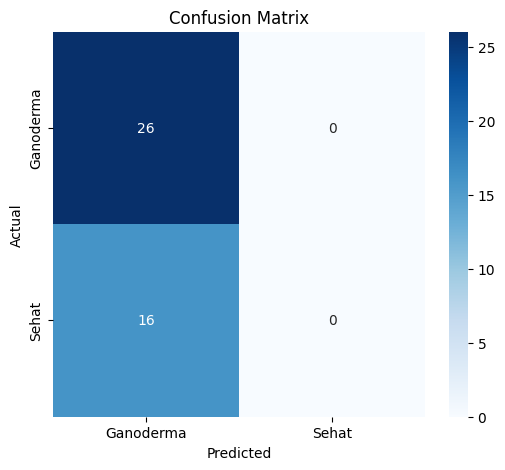


Classification Report:
              precision    recall  f1-score   support

   Ganoderma       0.62      1.00      0.76        26
       Sehat       0.00      0.00      0.00        16

    accuracy                           0.62        42
   macro avg       0.31      0.50      0.38        42
weighted avg       0.38      0.62      0.47        42



In [20]:
# ======================
# Evaluasi
# ======================
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")

# ======================
# Confusion Matrix
# ======================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================
# Classification Report
# ======================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))